In [2]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
gdf = gpd.read_file("../data/SANGIS/BUSINESS_SITES/BUSINESS_SITES.shp")


In [20]:
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

(1700000.0, 2200000.0)

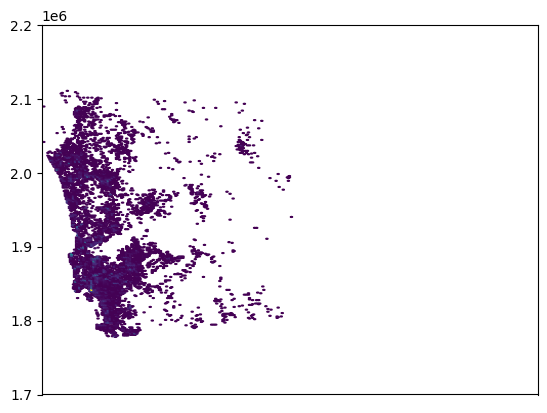

In [91]:
hexes = matplotlib.pyplot.hexbin( x= gdf['x'], y=gdf['y'],mincnt=1,gridsize=2000)
plt.xticks(range(1, 5))

plt.xlim(6200000, 7000000)
plt.ylim(1700000, 2200000)

In [81]:
hexbins = gpd.points_from_xy(x=[i[0] for i in hexes.get_offsets()],y=[i[1] for i in hexes.get_offsets()])[1:]

In [53]:
hexbins

<GeometryArray>
[<POINT (6180051.908 2128315.164)>, <POINT (6186654.527 2076674.934)>,
  <POINT (6196558.456 2050854.82)>,  <POINT (6203161.076 2041633.35)>,
 <POINT (6203161.076 2089584.992)>, <POINT (6209763.696 2023190.411)>,
 <POINT (6209763.696 2026878.999)>, <POINT (6213065.005 2017657.529)>,
 <POINT (6213065.005 2019501.823)>, <POINT (6213065.005 2021346.117)>,
 ...
 <POINT (6567955.807 1806485.878)>, <POINT (6567955.807 1992759.562)>,
 <POINT (6577859.736 1989070.974)>, <POINT (6581161.046 1804641.584)>,
 <POINT (6581161.046 1817551.641)>, <POINT (6581161.046 1998292.443)>,
 <POINT (6587763.666 1810174.465)>, <POINT (6597667.595 1989070.974)>,
 <POINT (6597667.595 1992759.562)>, <POINT (6597667.595 1994603.856)>]
Length: 5594, dtype: geometry

<Axes: >

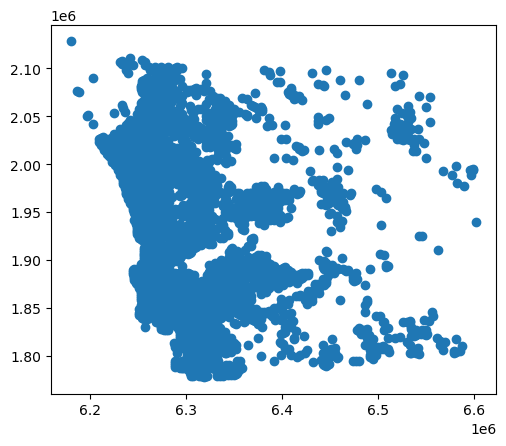

In [58]:
gpd.GeoDataFrame(geometry=hexbins).plot()

In [6]:
gdf['BUSTYPE'].value_counts()

BUSTYPE
MISC PROFESSIONAL       12397
CAFE                     5471
DOCTOR/OSTEOPA/CHIRO     4835
APARTMENTS               3769
PUBLIC AGENCY            2827
                        ...  
BATCHPLANT CONC/ASPH        2
MISC LIVESTOCK              2
SEE 501                     1
DAIRY CATTLE                1
BILLBOARDS                  1
Name: count, Length: 306, dtype: int64